# Notebook 2 — A 1-hidden-layer neural network (NumPy + manual backprop)

This notebook demonstrates:
- a small neural network written **from scratch** in NumPy,
- **manual backpropagation** (you compute gradients yourself),
- function approximation as a toy example of the *universal approximation* idea.

Target:
$$g(x)=\sin(x)\,x^3 - \tanh(x)$$

> Important note: The original script had a subtle derivative issue. In this notebook, we use the correct derivative for tanh:
> 
> If $a=\tanh(z)$, then $\frac{da}{dz} = 1 - a^2$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)


## 1. Target function + dataset
We sample 100 points in $[-\pi,\pi]$.


In [2]:
def target_function(x):
    return np.sin(x) * x**3 - np.tanh(x)

np.random.seed(0)
x_train = np.linspace(-np.pi, np.pi, 100).reshape(-1, 1)  # shape: (N, 1)
y_train = target_function(x_train)                        # shape: (N, 1)

print("x_train:", x_train.shape, " y_train:", y_train.shape)


x_train: (100, 1)  y_train: (100, 1)


## 2. Define the network
Architecture:
- Input dimension: 1
- Hidden layer: `hidden_dim` tanh units
- Output layer: linear

$$\text{Hidden: } z_1 = xW_1 + b_1,\quad a_1 = \tanh(z_1)$$
$$\text{Output: } \hat y = a_1W_2 + b_2$$


In [3]:
class SimpleNeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim, seed=0):
        rng = np.random.default_rng(seed)

        # He-like initialization helps keep activations in a reasonable range
        self.W1 = rng.standard_normal((input_dim, hidden_dim)) * np.sqrt(2 / input_dim)
        self.b1 = np.zeros((1, hidden_dim))

        self.W2 = rng.standard_normal((hidden_dim, output_dim)) * np.sqrt(2 / hidden_dim)
        self.b2 = np.zeros((1, output_dim))

    # --- activations ---
    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative_from_activation(self, a):
        """If a = tanh(z), then da/dz = 1 - a^2."""
        return 1.0 - a**2

    # --- forward pass ---
    def forward(self, x):
        # Hidden layer
        self.z1 = x @ self.W1 + self.b1            # (N, hidden_dim)
        self.a1 = self.tanh(self.z1)               # (N, hidden_dim)

        # Output layer (linear)
        self.y_pred = self.a1 @ self.W2 + self.b2  # (N, output_dim)
        return self.y_pred

    def train(self, x, y, epochs=10000, learning_rate=0.01, print_every=500):
        losses = []

        for epoch in range(epochs):
            # Forward
            y_pred = self.forward(x)

            # Loss: mean squared error
            loss = np.mean((y - y_pred) ** 2)
            losses.append(loss)

            # -------- Backprop --------
            # dL/dy_pred for MSE:
            # L = mean((y - y_pred)^2) = (1/N) * sum (y - y_pred)^2
            # dL/dy_pred = -2*(y - y_pred)/N
            N = y.size
            dL_dy_pred = -2.0 * (y - y_pred) / N

            # Output layer gradients
            dL_dW2 = self.a1.T @ dL_dy_pred              # (hidden_dim, output_dim)
            dL_db2 = np.sum(dL_dy_pred, axis=0, keepdims=True)

            # Backprop into hidden
            dL_da1 = dL_dy_pred @ self.W2.T              # (N, hidden_dim)
            dL_dz1 = dL_da1 * self.tanh_derivative_from_activation(self.a1)

            # Hidden layer gradients
            dL_dW1 = x.T @ dL_dz1                         # (input_dim, hidden_dim)
            dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)

            # Gradient descent step
            self.W2 -= learning_rate * dL_dW2
            self.b2 -= learning_rate * dL_db2
            self.W1 -= learning_rate * dL_dW1
            self.b1 -= learning_rate * dL_db1

            if epoch % print_every == 0:
                print(f"Epoch {epoch:5d} | Loss = {loss:.6f}")

        return np.array(losses)


## 3. Train and visualize
We use a relatively small network (e.g., 14 hidden units) and train with plain gradient descent.


Epoch     0 | Loss = 28.593437
Epoch   500 | Loss = 2.146434
Epoch  1000 | Loss = 1.427287
Epoch  1500 | Loss = 0.879410
Epoch  2000 | Loss = 0.563904
Epoch  2500 | Loss = 0.378676
Epoch  3000 | Loss = 0.264762
Epoch  3500 | Loss = 0.191442
Epoch  4000 | Loss = 0.142239
Epoch  4500 | Loss = 0.108034
Epoch  5000 | Loss = 0.083548
Epoch  5500 | Loss = 0.065593
Epoch  6000 | Loss = 0.052164
Epoch  6500 | Loss = 0.041957
Epoch  7000 | Loss = 0.034095
Epoch  7500 | Loss = 0.027973
Epoch  8000 | Loss = 0.023162
Epoch  8500 | Loss = 0.019355
Epoch  9000 | Loss = 0.016323
Epoch  9500 | Loss = 0.013899


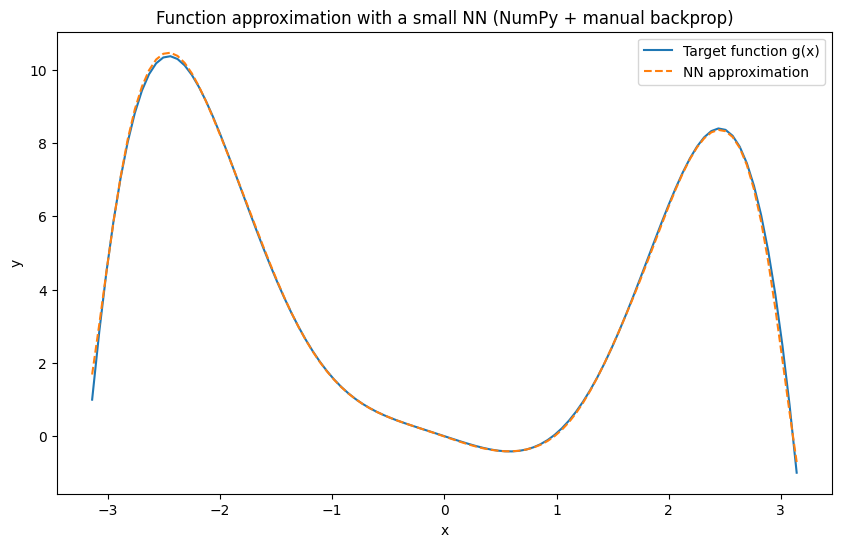

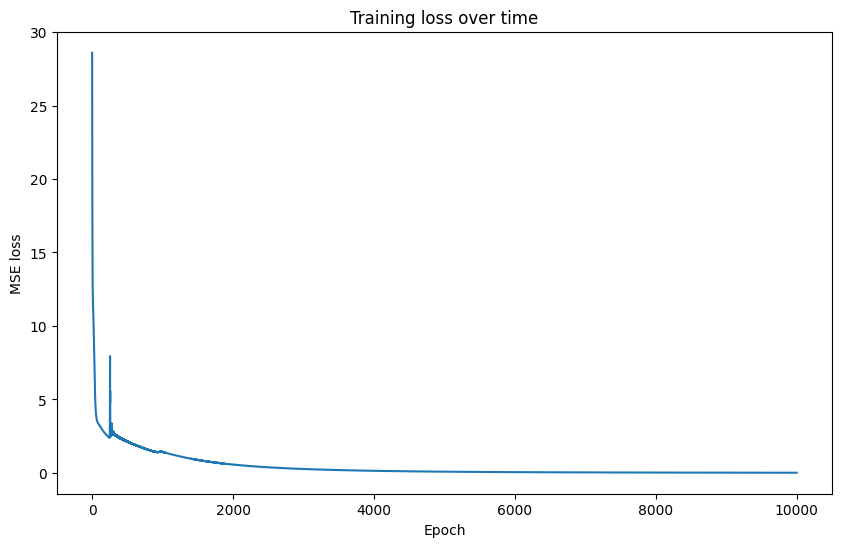

In [4]:
nn = SimpleNeuralNetwork(input_dim=1, hidden_dim=14, output_dim=1, seed=0)
losses = nn.train(x_train, y_train, epochs=10000, learning_rate=0.05, print_every=500)

y_pred = nn.forward(x_train)

# Plot fit
plt.figure()
plt.plot(x_train, y_train, label="Target function g(x)")
plt.plot(x_train, y_pred, "--", label="NN approximation")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Function approximation with a small NN (NumPy + manual backprop)")
plt.legend()
plt.show()

# Plot loss curve
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training loss over time")
plt.show()


## 4. Exercises
1. Change `hidden_dim` and see how it affects fit.
2. Try different learning rates (too big can diverge).
3. Add mini-batch training (instead of full batch).
4. Add L2 regularization on weights.
